In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)


1.13.1


## 数据导入 
IMDB数据集

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))


Training entries: 25000, labels: 25000


In [4]:
print(train_data[0])


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
len(train_data[0]), len(train_data[1])


(218, 189)


## 将整数转化回字词

In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [9]:
decode_review(train_data[0])


"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 准备数据 
影评（整数数组）必须转换为张量，然后才能馈送到神经网络中。

    采取填充数组，使它们都具有相同的长度，然后创建一个形状为 max_length * num_reviews 的整数张量。
    使用一个能够处理这种形状的嵌入层作为网络中的第一层。
    由于影评的长度必须相同，使用 pad_sequences 函数将长度标准化：

In [10]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)


In [11]:
len(train_data[0]),len(train_data[1])

(256, 256)

In [12]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 构建model
    Embedding层 （vocab_size，16）--> (batch, sequence, embedding)
    GlobalAveragePooling1D层 对序列维度求平均值，针对每个样本返回一个长度固定的输出向量
    Dense1 全连接层 16个节点 Relu
    Dense2 sigmoid 16 --> 1

In [13]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## 损失函数和优化器
Adam

binary_crossentropy

accuracy




In [14]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


## 创建验证集
从原始训练数据中分离出 10000 个样本，创建一个验证集。

In [15]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]


## 训练模型 
epochs=40,

batch_size=512

In [23]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 3s 201us/sample - loss: 0.0927 - acc: 0.9762 - val_loss: 0.3109 - val_acc: 0.8827
Epoch 2/40
15000/15000 [==============================] - 1s 74us/sample - loss: 0.0889 - acc: 0.9771 - val_loss: 0.3143 - val_acc: 0.8825
Epoch 3/40
15000/15000 [==============================] - 1s 76us/sample - loss: 0.0859 - acc: 0.9781 - val_loss: 0.3175 - val_acc: 0.8822
Epoch 4/40
15000/15000 [==============================] - 1s 82us/sample - loss: 0.0828 - acc: 0.9804 - val_loss: 0.3211 - val_acc: 0.8815
Epoch 5/40
15000/15000 [==============================] - 1s 73us/sample - loss: 0.0800 - acc: 0.9809 - val_loss: 0.3252 - val_acc: 0.8810
Epoch 6/40
15000/15000 [==============================] - 1s 75us/sample - loss: 0.0768 - acc: 0.9818 - val_loss: 0.3309 - val_acc: 0.8788
Epoch 7/40
15000/15000 [==============================] - 1s 74us/sample - loss: 0.0743 - acc: 0.9829 - val_loss: 0

## 评估模型
模型会返回两个值：损失（表示误差的数字，越低越好）和准确率。

In [17]:
results = model.evaluate(test_data, test_labels)

print(results)


25000/25000 [==============================] - 1s 34us/sample - loss: 0.3285 - acc: 0.8725
[0.32851289372444153, 0.87252]


## 创建准确率和损失随时间变化的图
model.fit() 返回一个 History 对象，该对象包含一个字典，其中包括训练期间发生的所有情况

In [18]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

一共有 4 个条目：每个条目对应训练和验证期间的一个受监控指标。我们可以使用这些指标绘制训练损失与验证损失图表以进行对比，并绘制训练准确率与验证准确率图表：

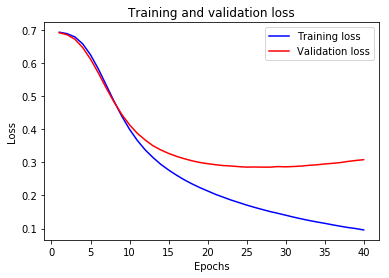

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'b', label='Training loss')

plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


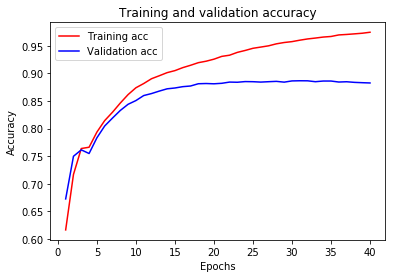

In [22]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


大概20多轮  测试集acc不在提高 训练集还在提高 出现过拟合 可以提前停止 
